In [35]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt


In [36]:
# Read both of the tables
# df_1 = pd.read_csv('./CatoPDF_Spring2022_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(0,9))
# df_2 = pd.read_csv('./CatoPDF_Spring2022_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(9,18))
df_1 = pd.read_csv('./Airbrakes_Spring2023_LORD.csv', skiprows=6, delimiter='\t', usecols=range(0,9))
df_2 = pd.read_csv('./Airbrakes_Spring2023_LORD.csv', skiprows=6, delimiter='\t', usecols=range(9,18))

In [37]:
# Merge the dataframes
df_m = pd.merge(df_1, df_2.rename(columns={'time.1':'time'}), on='time',  how='left')

# Interpolate missing values (since we merged on different sized tables
df_m.set_index('time', inplace=True)
#df_m.interpolate(method='index', inplace=True)
df_m.bfill(inplace=True)
df_m.reset_index(inplace=True)

# Constrain time to range we care about observing

# Cato 2022 Times
# tstart = 1450
# tend = 1500.5

# Spring2023 Airbrakes
tstart = 1510
tend = 1640.5

df_m = df_m[(df_m['time'] < tend) & (df_m['time'] > tstart)]

# Visually check that things look like
print(df_m.head())

                time   accel_x   accel_y   accel_z    gyro_x    gyro_y  \
1369059  1510.000977  0.026261  0.254280  9.901452 -0.661036  0.508776   
1369060  1510.001953  0.032398  0.255633  9.859144 -0.599678  0.089585   
1369061  1510.003052  0.025660  0.276184  9.778605 -0.491191 -0.098767   
1369062  1510.004028 -0.033876  0.293474  9.863058 -0.248746 -0.012001   
1369063  1510.005005 -0.037947  0.271977  9.799832 -0.290153 -0.028035   

           gyro_z  gps  gps.1    altitude  estLinearAccelX  estLinearAccelY  \
1369059  0.181873  0.0    4.0 -133.664383         0.008233        -0.066308   
1369060  0.012088  0.0    4.0 -133.664383         0.008233        -0.066308   
1369061  0.090633  0.0    4.0 -133.664383         0.068939         0.024452   
1369062  0.116597  0.0    4.0 -133.664383         0.068939         0.024452   
1369063 -0.017929  0.0    4.0 -133.664383        -0.004224         0.048634   

         estLinearAccelZ      roll     pitch       yaw  gps.2  
1369059         

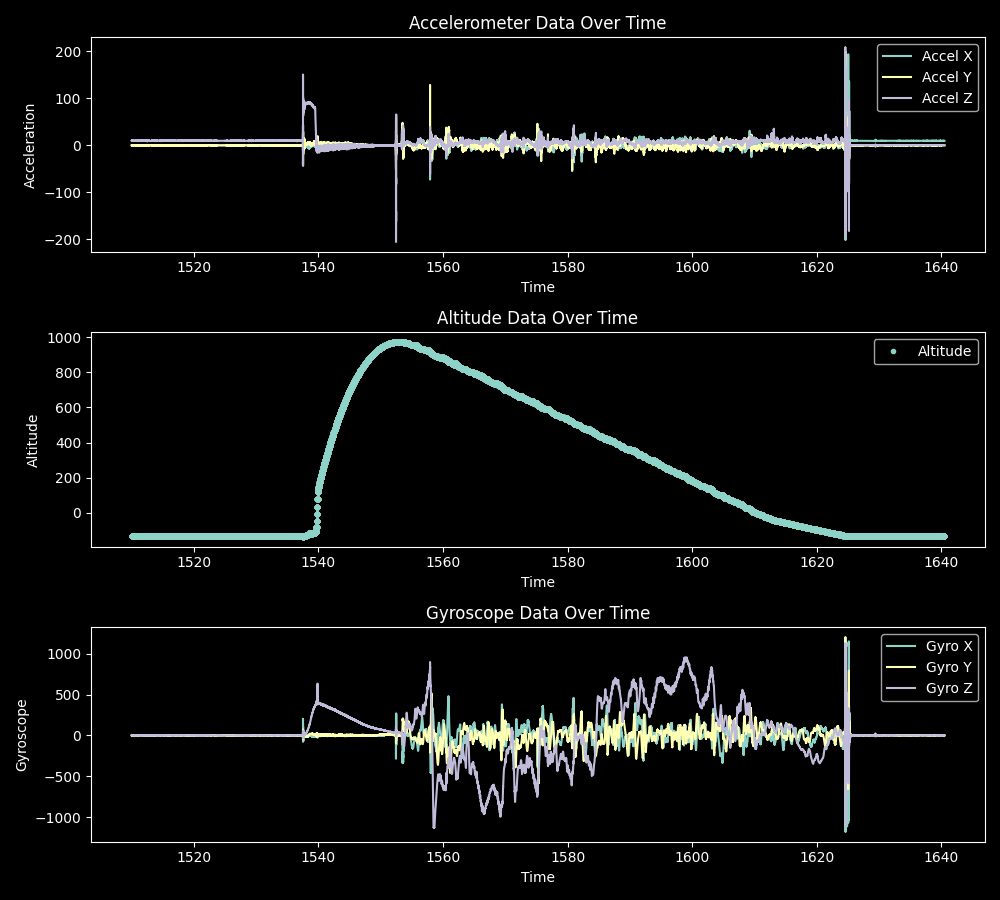

In [38]:
# Plot accelerometer data
plt.figure(figsize=(10, 9))
plt.subplot(3, 1, 1)
plt.plot(df_m['time'], df_m['accel_x'], label='Accel X')
plt.plot(df_m['time'], df_m['accel_y'], label='Accel Y')
plt.plot(df_m['time'], df_m['accel_z'], label='Accel Z')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Accelerometer Data Over Time')

# Plot Altitude data
plt.subplot(3, 1, 2)
plt.plot(df_m['time'], df_m['altitude'], '.', label='Altitude')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.title('Altitude Data Over Time')

# Plot gyroscope data
plt.subplot(3, 1, 3)
plt.plot(df_m['time'], df_m['gyro_x'], label='Gyro X')
plt.plot(df_m['time'], df_m['gyro_y'], label='Gyro Y')
plt.plot(df_m['time'], df_m['gyro_z'], label='Gyro Z')
plt.xlabel('Time')
plt.ylabel('Gyroscope')
plt.legend()
plt.title('Gyroscope Data Over Time')

# Show the plot
plt.tight_layout()
plt.show()

In [39]:
import numpy as np
'''
Module / Class created for simulating the flight of a rocket using 1D motion approximations.
All unites in SI / metric unless explicitly stated otherwise
'''
class rocket_model_1D:
    itmax = 10000 #maximum number of simulation iterations

    def __init__ (self, mass, area, drag_coeff, density_model = 1, gravtiy_model = 1):
        # Define the rocket
        self.mass = mass
        self.massi = 1/mass
        self.ref_area = area # reference area for the drag coefficient
        self.Cd = drag_coeff
        self.density_model = density_model
        self.gravity_model  = gravtiy_model
        self.state = np.array([0.0,0.0]) #state = np.array([position, velocity])

    def initialize(self, position, velocity):
      self.state[0] = position
      self.state[1] = velocity

    def set_timestep(self, dt):
      self.dt = dt

    def CdA(self):
      return self.Cd * self.ref_area

    def rho(self):
      if (self.density_model == 1):
        return 1.2
      else:
        return float('NaN')

    def g(self):
      if (self.gravity_model == 1):
       return 9.81
      else:
        return float('NaN')

    def drag_force(self, velocity):
      vmag = abs(velocity)
      return 0.5*self.rho()*vmag*velocity*self.CdA()

    def acceleration(self):
      return -self.drag_force(self.state[1])*self.massi - self.g()

    def euler_step(self):
      self.state += self.dt * np.array([self.state[1], self.acceleration()])

    def sim_to_apogee(self):
      iter = 0;
      self.height = []
      self.time = []

      self.height.append(self.state[0])
      self.time.append(0)

      while (self.state[1] > 0) and (iter < self.itmax):
        self.euler_step()

        self.height.append(self.state[0])
        self.time.append(self.time[iter] + self.dt)
        iter += 1

      return self.state[0]

In [40]:
import filterpy.kalman as kf
from filterpy.kalman import KalmanFilter
import numpy as np
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
from scipy.signal import butter, lfilter, freqz
import scipy
import mathutils
import math


In [41]:
time_series = df_m['time']
altitude_series = df_m['altitude']
accel_x_ser = df_m["estLinearAccelX"]
accel_y_ser = df_m["estLinearAccelY"]
accel_z_ser = df_m["estLinearAccelZ"]
gyro_x_ser = df_m["gyro_x"]
gyro_y_ser = df_m["gyro_y"]
gyro_z_ser = df_m["gyro_z"]

In [42]:
gravity_accel = -9.81 # m/s per second

rho = 1.2


def getApogeeEstimate(current_alt, current_velocity, Cd, area, mass, accel_multiplier):
    # trajectory formula
    # a(x**2) + bx + c
    # (0.5 * (gravity_accel + drag_accel))(x**2) + (velo)x + (current_alt)
    # where x is time
    
    vmag = abs(current_velocity)
    drag_force = -0.5 * rho * vmag * current_velocity * Cd * area
    drag_accel = drag_force / mass

    a = (0.5 * ((gravity_accel + drag_accel) * accel_multiplier))
    b = current_velocity
    c = current_alt
    
    # get vertex X (-b/2a)
    vertex_x = (-b) / (2 * a)
    
    # return the y-value at that location
    return (a * (vertex_x**2)) + (b * vertex_x) + c

In [43]:
altitude_data = altitude_series.to_numpy()
time_data = time_series.to_numpy()

accel_x = accel_x_ser.to_numpy()
accel_y = accel_y_ser.to_numpy()
accel_z = accel_z_ser.to_numpy()

gyro_x = gyro_x_ser.to_numpy()
gyro_y = gyro_y_ser.to_numpy()
gyro_z = gyro_z_ser.to_numpy()

def FirstOrderKF(R, Q, dt):
    """ Create first order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf


R, Q = 0.02, 0.08

tracker = FirstOrderKF(R, Q, dt=1)
accel_kf = FirstOrderKF(0.02, 0.08, dt=1)

accel_kf.alpha = 1.0005
tracker.alpha = 1.0005

current_time_index = 0
dt = 1

time_values = []
pos_estimates = []
vel_estimates = []

apogee_estimates = []

accel_actual_values = []
accel_estimates = []
orient_diff_vals = []
up_orientation = mathutils.Euler([0,0,1]).to_quaternion()


# Parameters for quadratic model
quad_mass = 25     #kg
quad_area = 0.15    #m
quad_Cd = 0.023       #drag coefficient
quad_accel_multiplier = 1.27 # Not sure if fudge, need to test with more data

# Set parameters for 1D rocket model

rkt_mass = 50     #kg
rxt_area = 0.07    #m
Cd = 0.9 #0.06         #drag coefficient

apogee_model_estimates = []

rocket_model = rocket_model_1D(rkt_mass, rxt_area, Cd)


for index, value in enumerate(time_data):
    if (index > 0):
        dt = value - time_data[index-1]


    noise = Q_discrete_white_noise(2, dt, Q)

    tracker.F = np.array([[1., dt],
                          [0., 1]])
    
    tracker.Q = noise

    
    tracker.predict()
    
    tracker.update(altitude_data[index])
        
    
    current_accel = mathutils.Vector((accel_x[index], accel_y[index], accel_z[index]))
    # add a - sign to current_accel if the imu is upside down like in CatoPDF_Spring2022 lol
    
    current_orientation = mathutils.Euler((math.radians(gyro_x[index]), 
                                           math.radians(gyro_y[index]), 
                                           math.radians(gyro_z[index])))
    
    current_accel.rotate(current_orientation)
    
    accel_actual_values.append(current_accel.z)
    
    current_quat = current_orientation.to_quaternion()
    diff = current_quat.dot(up_orientation)
    orient_diff_vals.append(diff)
    
    
    accel_kf.F = np.array([[1., dt],
                          [0., 1]])
    
    accel_kf.Q = noise

    
    accel_kf.predict()
    
    accel_kf.update(current_accel.z)

    accel_estimates.append(accel_kf.x[0])
    
    time_values.append(value)
    pos_estimates.append(tracker.x[0])
    vel_estimates.append(tracker.x[1])
    
    current_apogee_est = getApogeeEstimate(tracker.x[0], tracker.x[1],
                                           quad_Cd, quad_area, quad_mass, quad_accel_multiplier)
    apogee_estimates.append(current_apogee_est)
    
    rocket_model.initialize(tracker.x[0], tracker.x[1])
    
    # Time step to calculate 1D rocket model (smaller increases accuracy, but slows down perf a lot)
    rocket_model.set_timestep(1)
    
    model_estimate = rocket_model.sim_to_apogee()
    
    apogee_model_estimates.append(model_estimate)
    
    
    

Text(0.5, 1.0, 'Acceleration Data Over Time')

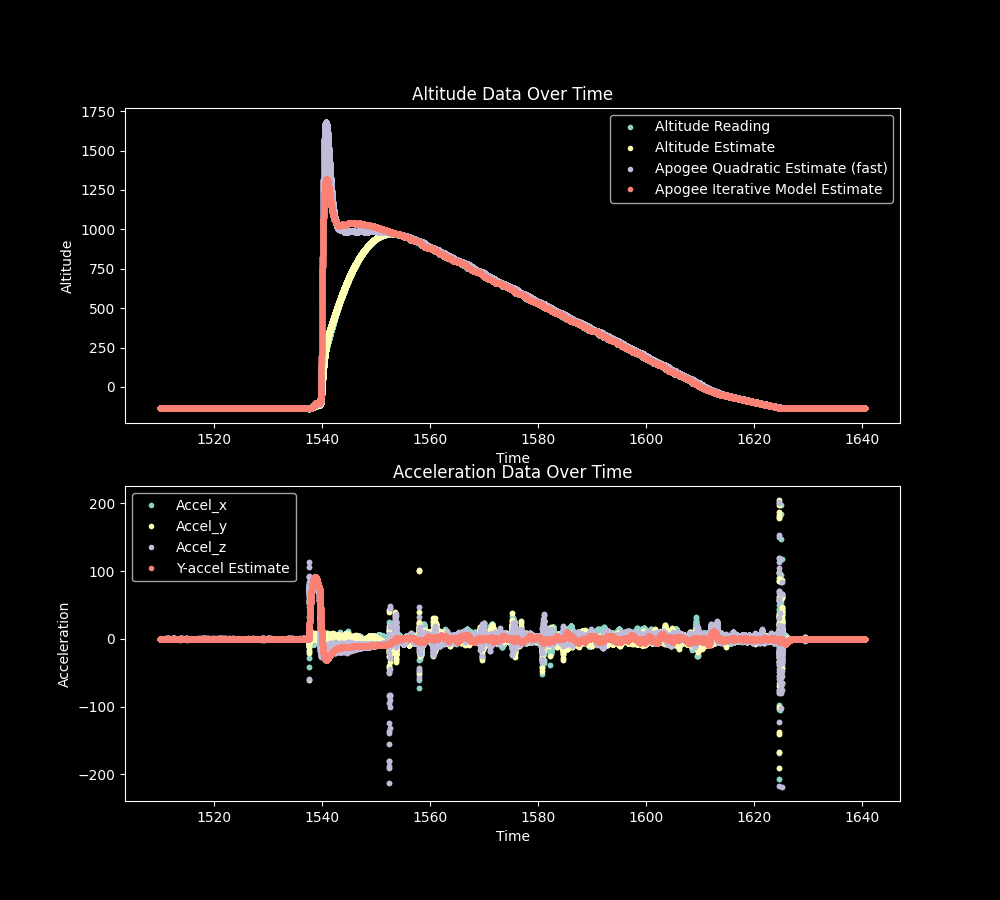

In [47]:
plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
plt.plot(time_series, altitude_data, '.', label='Altitude Reading')
plt.plot(time_values, pos_estimates, '.',  label='Altitude Estimate')
plt.plot(time_values, apogee_estimates, '.',  label='Apogee Quadratic Estimate (fast)')
plt.plot(time_values, apogee_model_estimates, '.',  label='Apogee Iterative Model Estimate')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.title('Altitude Data Over Time')


plt.subplot(2, 1, 2)

#plt.plot(time_values, vel_estimates, '.', label='Y-velocity Estimate')

#plt.plot(time_values, orient_diff_vals, '.', label='Deviance from straight up')
plt.plot(time_values, accel_x, '.', label='Accel_x')
plt.plot(time_values, accel_y, '.', label='Accel_y')
plt.plot(time_values, accel_z, '.', label='Accel_z')
plt.plot(time_values, accel_estimates, '.', label='Y-accel Estimate')

plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Acceleration Data Over Time')


Text(0.5, 1.0, 'Some Data Over Time')

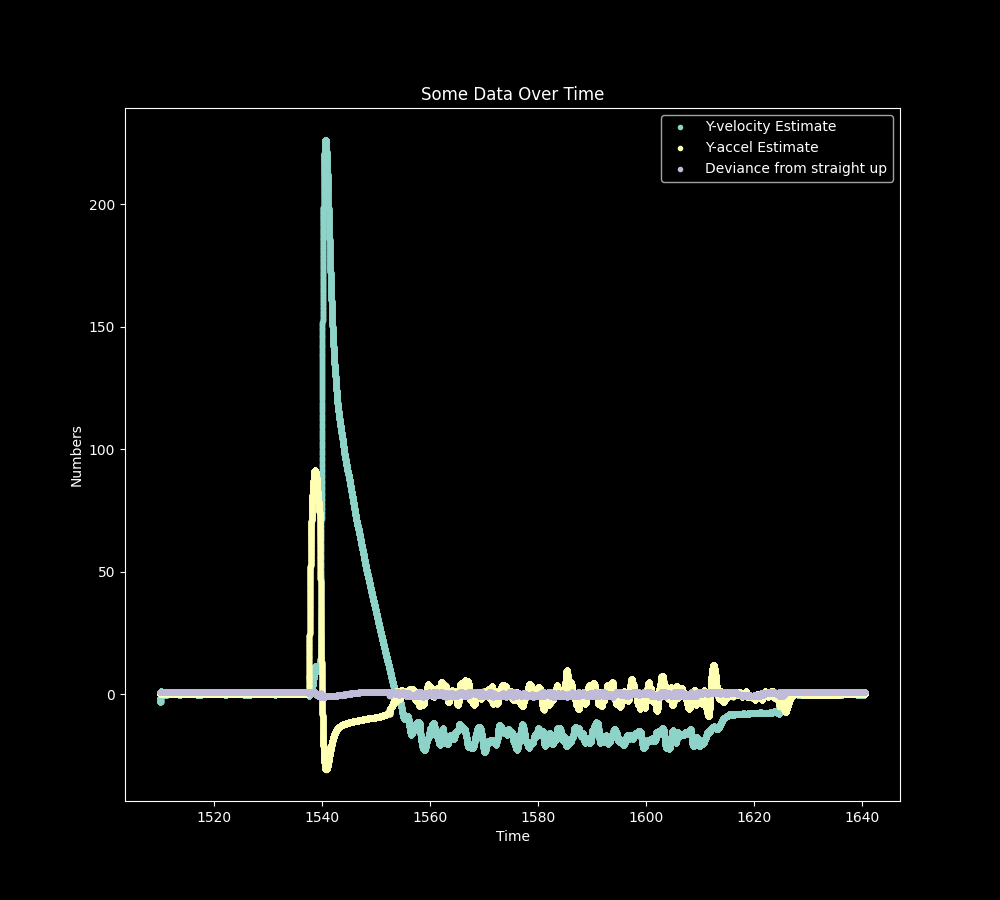

In [45]:
plt.figure(figsize=(10, 9))
plt.plot(time_values, vel_estimates, '.', label='Y-velocity Estimate')
plt.plot(time_values, accel_estimates, '.', label='Y-accel Estimate')
plt.plot(time_values, orient_diff_vals, '.', label='Deviance from straight up')

plt.xlabel('Time')
plt.ylabel('Numbers')
plt.legend()
plt.title('Some Data Over Time')

Text(0.5, 1.0, 'Deriv_Altitude Data Over Time')

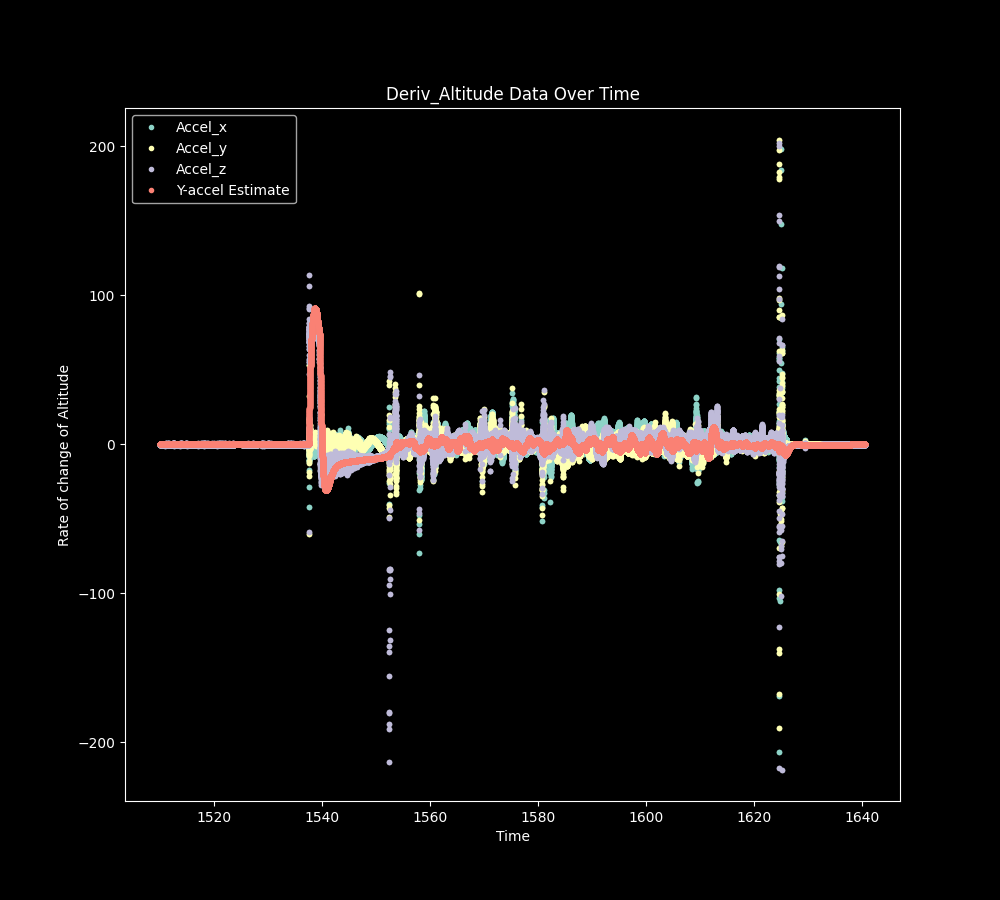

In [46]:
plt.figure(figsize=(10, 9))
#plt.plot(time_values, vel_estimates, '.', label='Y-velocity Estimate')

#plt.plot(time_values, orient_diff_vals, '.', label='Deviance from straight up')
plt.plot(time_values, accel_x, '.', label='Accel_x')
plt.plot(time_values, accel_y, '.', label='Accel_y')
plt.plot(time_values, accel_z, '.', label='Accel_z')
plt.plot(time_values, accel_estimates, '.', label='Y-accel Estimate')

plt.xlabel('Time')
plt.ylabel('Rate of change of Altitude')
plt.legend()
plt.title('Deriv_Altitude Data Over Time')
